<a href="https://colab.research.google.com/github/Yash-2808/Distracted-Driver-Detection-using-deep-learning/blob/main/driver3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import os
import pickle




In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yashsrivastava08","key":"ce5ea8b34652eafc0dea83b9b0f4e303"}'}

In [ ]:
# upload kaggle.json first
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json




In [ ]:
!kaggle competitions download -c state-farm-distracted-driver-detection
!unzip state-farm-distracted-driver-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: imgs/train/c7/img_56636.jpg  
  inflating: imgs/train/c7/img_56661.jpg  
  inflating: imgs/train/c7/img_56699.jpg  
  inflating: imgs/train/c7/img_56717.jpg  
  inflating: imgs/train/c7/img_56724.jpg  
  inflating: imgs/train/c7/img_56768.jpg  
  inflating: imgs/train/c7/img_56779.jpg  
  inflating: imgs/train/c7/img_56849.jpg  
  inflating: imgs/train/c7/img_56899.jpg  
  inflating: imgs/train/c7/img_56938.jpg  
  inflating: imgs/train/c7/img_5706.jpg  
  inflating: imgs/train/c7/img_57076.jpg  
  inflating: imgs/train/c7/img_57122.jpg  
  inflating: imgs/train/c7/img_57137.jpg  
  inflating: imgs/train/c7/img_5715.jpg  
  inflating: imgs/train/c7/img_57278.jpg  
  inflating: imgs/train/c7/img_57321.jpg  
  inflating: imgs/train/c7/img_57345.jpg  
  inflating: imgs/train/c7/img_57355.jpg  
  inflating: imgs/train/c7/img_5741.jpg  
  inflating: imgs/train/c7/img_57433.jpg  
  inflating: imgs/train/c7/img_5753.jpg  
  infla

In [ ]:
DATA_DIR = "/content/state-farm-distracted-driver-detection/imgs/train"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 10
SEED = 42


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

class_names = train_ds.class_names
print(class_names)


Found 22424 files belonging to 10 classes.
Using 17940 files for training.
Found 22424 files belonging to 10 classes.
Using 4484 files for validation.
['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']


In [ ]:
import pickle

class_names = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9']

labels = {name: i for i, name in enumerate(class_names)}

with open("labels.pkl", "wb") as f:
    pickle.dump(labels, f)

print("labels.pkl created successfully")
print(labels)


labels.pkl created successfully
{'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}


In [ ]:
labels = {name: i for i, name in enumerate(class_names)}

with open("labels.pkl", "wb") as f:
    pickle.dump(labels, f)

print("labels.pkl created:", labels)


labels.pkl created: {'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.15),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.1),
])


In [ ]:
def mixup(images, labels, alpha=0.2):
    batch_size = tf.shape(images)[0]
    lam = tf.random.gamma([batch_size], alpha)
    lam = tf.reshape(lam, (batch_size, 1, 1, 1))

    index = tf.random.shuffle(tf.range(batch_size))

    mixed_images = lam * images + (1 - lam) * tf.gather(images, index)
    mixed_labels = lam[:,0,0,0][:,None] * labels + \
                   (1 - lam[:,0,0,0][:,None]) * tf.gather(labels, index)
    return mixed_images, mixed_labels


In [ ]:
train_ds = train_ds.map(
    lambda x, y: mixup(x, y),
    num_parallel_calls=tf.data.AUTOTUNE
)


In [ ]:
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=IMG_SIZE + (3,)
)

base_model.trainable = False


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)

x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385,197 (16.73 MB)

 Trainable params: 333,066 (1.27 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=1e-3,
        weight_decay=1e-4
    ),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)


In [ ]:
history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)


Epoch 1/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 92s 133ms/step - accuracy: 0.2988 - loss: 2.5844 - val_accuracy: 0.6893 - val_loss: 1.2876
Epoch 2/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 63s 112ms/step - accuracy: 0.4895 - loss: 1.7474 - val_accuracy: 0.7616 - val_loss: 1.1725
Epoch 3/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 81s 111ms/step - accuracy: 0.5382 - loss: 1.6031 - val_accuracy: 0.7647 - val_loss: 1.1331
Epoch 4/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 62s 110ms/step - accuracy: 0.5708 - loss: 1.5439 - val_accuracy: 0.8218 - val_loss: 1.0720
Epoch 5/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 62s 111ms/step - accuracy: 0.5844 - loss: 1.5076 - val_accuracy: 0.8024 - val_loss: 1.0706
Epoch 6/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 72s 128ms/step - accuracy: 0.5977 - loss: 1.4756 - val_accuracy: 0.7763 - val_loss: 1.0820
Epoch 7/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 62s 110ms/step - accuracy: 0.6071 - loss: 1.4610 - val_accuracy: 0.8180 - val_loss: 1.0385
Epoch 8/10
561/561 ━━━━━━━━━━━━━━━━━━━━ 62s 111ms/step - accuracy: 0.6073 - loss: 1

In [ ]:
import matplotlib.pyplot as plt


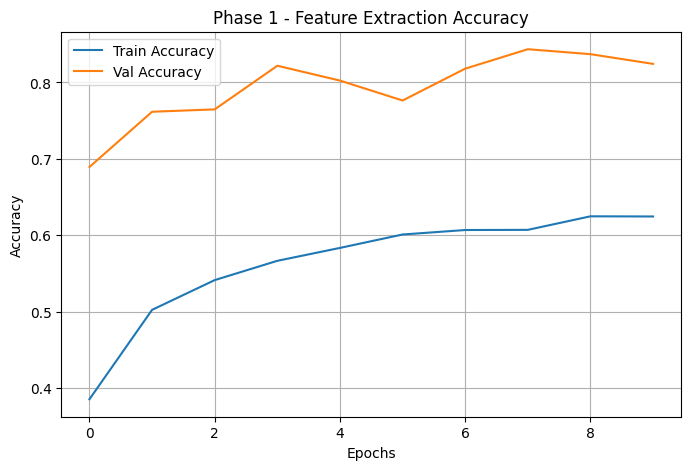

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history1.history['accuracy'], label='Train Accuracy')
plt.plot(history1.history['val_accuracy'], label='Val Accuracy')
plt.title('Phase 1 - Feature Extraction Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


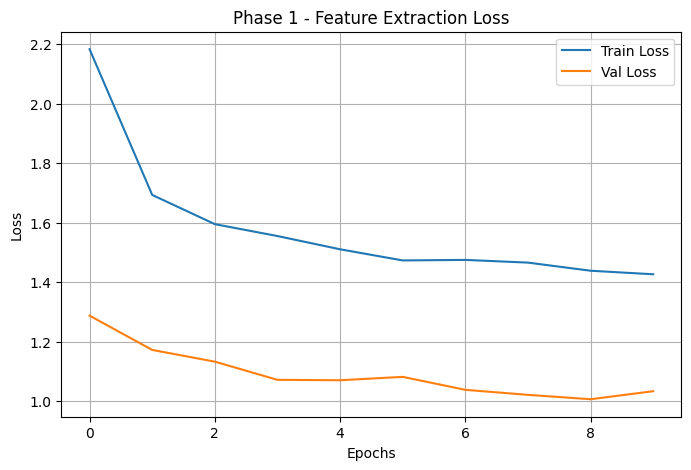

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.title('Phase 1 - Feature Extraction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-50]:
    layer.trainable = False


In [ ]:
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    alpha=1e-6
)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=lr_schedule,
        weight_decay=1e-5
    ),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=["accuracy"]
)


In [ ]:
history2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
)


Epoch 1/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 104s 149ms/step - accuracy: 0.5643 - loss: 1.5713 - val_accuracy: 0.9175 - val_loss: 0.8474
Epoch 2/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 90s 161ms/step - accuracy: 0.7728 - loss: 1.1715 - val_accuracy: 0.9373 - val_loss: 0.8146
Epoch 3/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 81s 143ms/step - accuracy: 0.8217 - loss: 1.0658 - val_accuracy: 0.9532 - val_loss: 0.7692
Epoch 4/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 81s 144ms/step - accuracy: 0.8398 - loss: 1.0530 - val_accuracy: 0.9623 - val_loss: 0.7404
Epoch 5/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 81s 144ms/step - accuracy: 0.8524 - loss: 0.8607 - val_accuracy: 0.9654 - val_loss: 0.8023
Epoch 6/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 81s 144ms/step - accuracy: 0.8635 - loss: 0.8498 - val_accuracy: 0.9657 - val_loss: 0.7719
Epoch 7/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 80s 142ms/step - accuracy: 0.8680 - loss: 0.7215 - val_accuracy: 0.9670 - val_loss: 0.8029
Epoch 8/20
561/561 ━━━━━━━━━━━━━━━━━━━━ 93s 161ms/step - accuracy: 0.8686 - loss: 

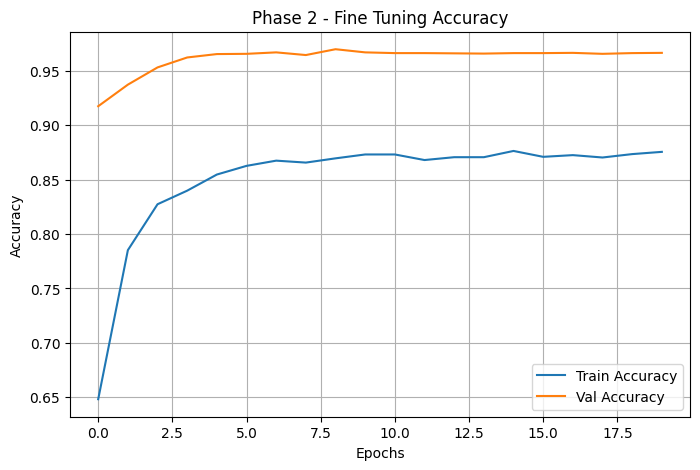

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.title('Phase 2 - Fine Tuning Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


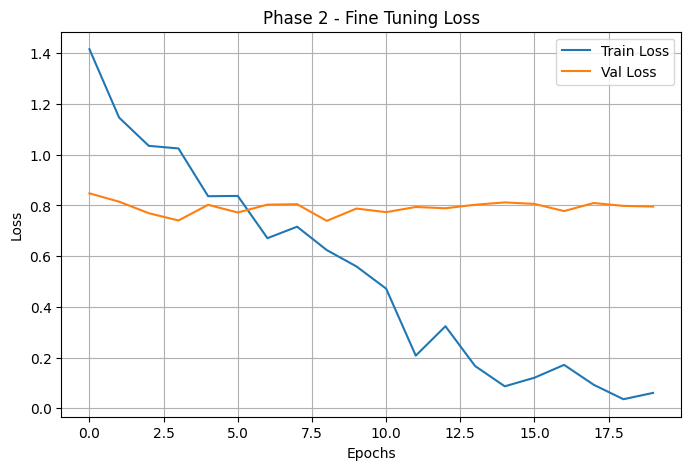

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title('Phase 2 - Fine Tuning Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np


In [ ]:
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 1

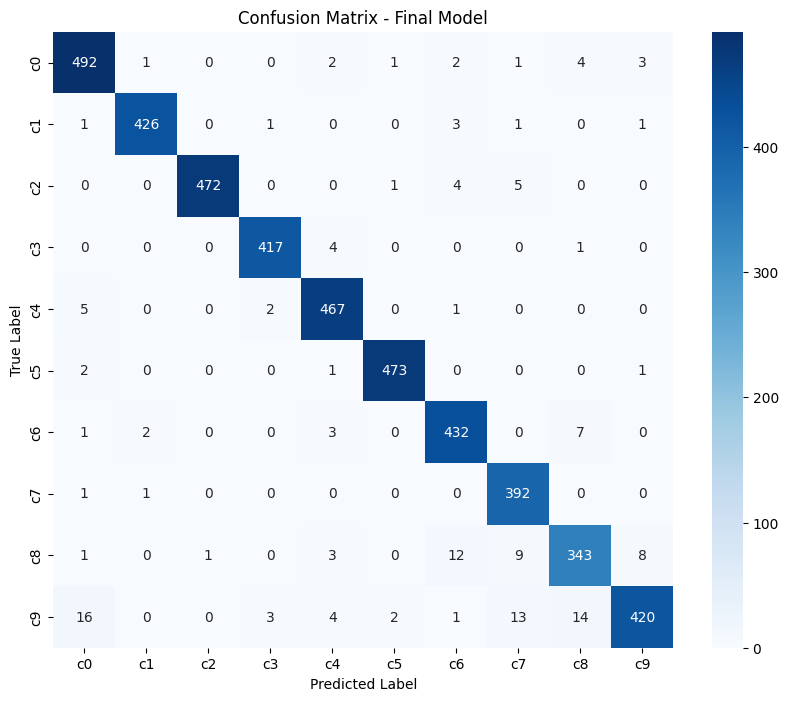

In [34]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Final Model")
plt.show()


In [35]:
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4
))


              precision    recall  f1-score   support

          c0     0.9480    0.9723    0.9600       506
          c1     0.9907    0.9838    0.9873       433
          c2     0.9979    0.9793    0.9885       482
          c3     0.9858    0.9882    0.9870       422
          c4     0.9649    0.9832    0.9739       475
          c5     0.9916    0.9916    0.9916       477
          c6     0.9495    0.9708    0.9600       445
          c7     0.9311    0.9949    0.9620       394
          c8     0.9295    0.9098    0.9196       377
          c9     0.9700    0.8879    0.9272       473

    accuracy                         0.9665      4484
   macro avg     0.9659    0.9662    0.9657      4484
weighted avg     0.9669    0.9665    0.9664      4484



In [36]:
print("Final Training Accuracy:",
      round(history2.history['accuracy'][-1]*100,2), "%")

print("Final Validation Accuracy:",
      round(history2.history['val_accuracy'][-1]*100,2), "%")


Final Training Accuracy: 87.55 %
Final Validation Accuracy: 96.65 %


In [ ]:
model.save("v7_plus_distracted_driver.keras")
print("Model saved successfully ✔")


Model saved successfully ✔
